## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [1]:
initial_technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [2]:
import pandas as pd
import re
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

**\<Changes\>**

In [10]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
maximun_number_of_tickers = 4000
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

**\</Changes\>**

## 1. Initial exploring

In [11]:
data_set = pd.read_feather("data/financials_against_return.feather")

In [12]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})

df_quarter_lengths

,execution_date,count
0,2005-06-30,1962
1,2005-09-30,1992
2,2005-12-30,2005
3,2006-03-31,2036
4,2006-06-30,2052
...,...,...
59,2020-03-31,3535
60,2020-06-30,3536
61,2020-09-30,3651
62,2020-12-30,3720


In [13]:
df_quarter_lengths["count"].describe()

count      64.000000
mean     2663.796875
std       495.753177
min      1962.000000
25%      2238.750000
50%      2530.000000
75%      3040.000000
max      3720.000000
Name: count, dtype: float64

//// Como vemos ningún quarter tiene menos de 1500 acciones por lo que en el notebook inicial no estaríamos filtrando nada

**\<Changes\>**

Remove these quarters which have les than `minimum_number_of_tickers` tickers and more than `maximun_number_of_tickers`:

In [14]:
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])

data_set = data_set[
        (data_set["count"] >= minimum_number_of_tickers) & (data_set["count"] <= maximun_number_of_tickers)
    ]

**\</Changes\>**

In [15]:
data_set.shape

(170483, 145)

In [16]:
data_set["execution_date"].unique()

<DatetimeArray>
['2005-06-30 00:00:00', '2005-09-30 00:00:00', '2005-12-30 00:00:00',
 '2006-03-31 00:00:00', '2006-06-30 00:00:00', '2006-09-30 00:00:00',
 '2006-12-30 00:00:00', '2007-03-31 00:00:00', '2007-06-30 00:00:00',
 '2007-09-30 00:00:00', '2007-12-30 00:00:00', '2008-03-31 00:00:00',
 '2008-06-30 00:00:00', '2008-09-30 00:00:00', '2008-12-30 00:00:00',
 '2009-03-31 00:00:00', '2009-06-30 00:00:00', '2009-09-30 00:00:00',
 '2009-12-30 00:00:00', '2010-03-31 00:00:00', '2010-06-30 00:00:00',
 '2010-09-30 00:00:00', '2010-12-30 00:00:00', '2011-03-31 00:00:00',
 '2011-06-30 00:00:00', '2011-09-30 00:00:00', '2011-12-30 00:00:00',
 '2012-03-31 00:00:00', '2012-06-30 00:00:00', '2012-09-30 00:00:00',
 '2012-12-30 00:00:00', '2013-03-31 00:00:00', '2013-06-30 00:00:00',
 '2013-09-30 00:00:00', '2013-12-30 00:00:00', '2014-03-31 00:00:00',
 '2014-06-30 00:00:00', '2014-09-30 00:00:00', '2014-12-30 00:00:00',
 '2015-03-31 00:00:00', '2015-06-30 00:00:00', '2015-09-30 00:00:00',
 '20

## 2. Looking at features

In [17]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170483 entries, 0 to 170482
Columns: 145 entries, Ticker to count
dtypes: datetime64[ns](2), float64(141), int64(1), object(1)
memory usage: 188.6+ MB


In [18]:
columns = []
for col, index in zip(data_set.columns, range(len(data_set.columns))):
    columns.append((index, col))
    print((index, col))

(0, 'Ticker')
(1, 'date')
(2, 'AssetTurnover')
(3, 'CashFlowFromFinancialActivities')
(4, 'CashFlowFromInvestingActivities')
(5, 'CashFlowFromOperatingActivities')
(6, 'CashOnHand')
(7, 'ChangeInAccountsPayable')
(8, 'ChangeInAccountsReceivable')
(9, 'ChangeInAssetsLiabilities')
(10, 'ChangeInInventories')
(11, 'CommonStockDividendsPaid')
(12, 'CommonStockNet')
(13, 'ComprehensiveIncome')
(14, 'CostOfGoodsSold')
(15, 'CurrentRatio')
(16, 'DaysSalesInReceivables')
(17, 'DebtIssuanceRetirementNet_minus_Total')
(18, 'DebtEquityRatio')
(19, 'EBIT')
(20, 'EBITMargin')
(21, 'EBITDA')
(22, 'EBITDAMargin')
(23, 'FinancialActivities_minus_Other')
(24, 'GoodwillAndIntangibleAssets')
(25, 'GrossMargin')
(26, 'GrossProfit')
(27, 'IncomeAfterTaxes')
(28, 'IncomeFromContinuousOperations')
(29, 'IncomeFromDiscontinuedOperations')
(30, 'IncomeTaxes')
(31, 'Inventory')
(32, 'InventoryTurnoverRatio')
(33, 'InvestingActivities_minus_Other')
(34, 'LongTermDebt')
(35, 'Long_minus_TermInvestments')
(36, 'Lo

In [ ]:
features_data = []
index_list = []
for col, index in zip(data_set.columns, range(len(data_set.columns))):
    features_data.append({
        'name': col,
        'data_type': str(data_set[col].dtype),
        'nulls': data_set[col].isna().sum(),
        'nuniques': data_set[col].nunique()
    })
    index_list.append(index)

features_info = pd.DataFrame(features_data, index=index_list)

features_info

,name,data_type,nulls,nuniques
0,Ticker,object,0,3845
1,date,datetime64[ns],0,192
2,AssetTurnover,float64,7114,10541
3,CashFlowFromFinancialActivities,float64,1940,95195
4,CashFlowFromInvestingActivities,float64,1930,90068
...,...,...,...,...
140,CurrentRatio_change_2_years,float64,59767,108994
141,Market_cap__minus_365,float64,15242,154913
142,Market_cap__minus_730,float64,29386,140825
143,diff_ch_sp500,float64,14217,155843


//// Observando todas las features del dataset saco una lista con las 'técnicas' `technical_features_v2`

In [28]:
technical_features_v2 = [
    'close_0',
    'close_sp500_0',
    'stock_change_365',
    'stock_change_div_365',
    'sp500_change_365',
    'stock_change_730',
    'stock_change_div_730',
    'sp500_change_730',
    'stock_change__minus_120',
    'stock_change_div__minus_120',
    'sp500_change__minus_120',
    'stock_change__minus_365',
    'stock_change_div__minus_365',
    'sp500_change__minus_365',
    'stock_change__minus_730',
    'stock_change_div__minus_730',
    'sp500_change__minus_730',
    'std_730', 'std__minus_120',
    'std__minus_365',
    'std__minus_730'
    ]

initial_technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']



diff_1 = [col for col in initial_technical_features if col not in technical_features_v2]
print(f"Features in technical_features that are not in technical_features_v2 (total: {len(diff_1)}): \n{diff_1}")


diff_2 = [col for col in technical_features_v2 if col not in initial_technical_features]
print(f"\nFeatures in technical_features_v2 that are not in technical_features (total: {len(diff_2)}): \n{diff_2}")


diff_3 = [col for col in initial_technical_features if col not in data_set.columns]
print(f"\nVariables in initial_technical_features that no longer exist in the dataset (total: {len(diff_3)}): \n{diff_3}")


Features in technical_features that are not in technical_features_v2 (total: 8): 
['close_365', 'close_sp500_365', 'close__minus_120', 'close_sp500__minus_120', 'close__minus_365', 'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730']

Features in technical_features_v2 that are not in technical_features (total: 7): 
['stock_change_730', 'stock_change_div_730', 'sp500_change_730', 'stock_change_div__minus_120', 'stock_change_div__minus_365', 'stock_change_div__minus_730', 'std_730']

Variables in initial_technical_features that no longer exist in the dataset (total: 8): 
['close_365', 'close_sp500_365', 'close__minus_120', 'close_sp500__minus_120', 'close__minus_365', 'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730']


//// Parece que varias de las columnas técnicas han cambiado de nombre. Es importante darse cuenta de esto ya que nos podría causar errores que no se ven a simple vista más adelante.

## 3. Creating the target

In [29]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

## 4. Defining the main metric

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [89]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

## 5. Data splits

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

**\<Changes\>**

In [90]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

**\</Changes\>**

Ensure that we don't include features which are irrelevant or related to the target:

In [91]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count",
                         ]
        
    return columns_to_remove

In [ ]:
# Features in columns_to_remove que no existen en el dataset
diff_4 = [col for col in columns_to_remove if col not in data_set.columns]
print(f"\nFeatures in columns_to_remove que no existen en el dataset (total: {len(diff_4)}): \n{diff_4}")


columns_to_remove = [
                     "date",
                     "improve_sp500",
                     "Ticker",
                     "freq",
                     "set",
                     "close_sp500_365",
                     "close_365",
                     "stock_change_365",
                     "sp500_change_365",
                     "stock_change_div_365",
                     "stock_change_730",
                     "sp500_change_365",
                     "stock_change_div_730",
                     "diff_ch_sp500",
                     "diff_ch_avg_500",
                     "execution_date","target","index","quarter","std_730","count",
                     ]

# Encontrar las variables de technical_features que no están en columns_to_remove
not_in_columns_to_remove = [var for var in technical_features if var not in columns_to_remove]

print('Variables de technical_features que no están en columns_to_remove:')
for var in not_in_columns_to_remove:
    print(f'- {var}')

print(f'\nTotal: {len(not_in_columns_to_remove)} variables encontradas')

This is the main modeling function, it receives a train set and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [92]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [93]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,all_probs,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        y_train = train_set["target"]
        y_test = test_set["target"]
        
        print(f"\ntrain_size: {train_size}, test_size: {test_size}")
        print(f"Nº quarters train: {len(train_set['execution_date'].unique())}, Nº quarters test: {len(test_set['execution_date'].unique())}")
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)

            train_probs = model.predict(X_train)
            test_probs = model.predict(X_test)
            all_probs[(execution_date.astype(str))] = [train_probs,test_probs]
            
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, y_train, y_test, all_probs


execution_dates = np.sort( data_set['execution_date'].unique() )
execution_dates = execution_dates[[10, 28, 58]]


In [94]:
def evaluate_model_performance(y_true_train, y_pred_proba_train, y_true_test, y_pred_proba_test, figsize=(15, 6)):
    """
    Evaluate model performance using ROC and precision-recall curves for both training and test sets
    
    Parameters:
    -----------
    y_true_train : array-like
        True binary labels for training set
    y_pred_proba_train : array-like
        Predicted probabilities for training set
    y_true_test : array-like
        True binary labels for test set
    y_pred_proba_test : array-like
        Predicted probabilities for test set
    figsize : tuple, optional
        Figure size (width, height)
    
    Returns:
    --------
    tuple
        (fig, (ax1, ax2)) - Figure and axes objects for further customization if needed
    """
    from sklearn.metrics import (
        roc_curve,
        auc,
        precision_recall_curve,
        average_precision_score,
        confusion_matrix,
        classification_report
    )
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # ROC Curves
    # Training set
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    # Test set
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Plot ROC curves
    ax1.plot(fpr_train, tpr_train, color='darkorange', lw=2, 
             label=f'Train ROC (AUC = {roc_auc_train:.3f})')
    ax1.plot(fpr_test, tpr_test, color='blue', lw=2,
             label=f'Test ROC (AUC = {roc_auc_test:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # Precision-Recall Curves
    # Training set
    precision_train, recall_train, _ = precision_recall_curve(y_true_train, y_pred_proba_train)
    average_precision_train = average_precision_score(y_true_train, y_pred_proba_train)
    
    # Test set
    precision_test, recall_test, _ = precision_recall_curve(y_true_test, y_pred_proba_test)
    average_precision_test = average_precision_score(y_true_test, y_pred_proba_test)
    
    # Plot PR curves
    ax2.plot(recall_train, precision_train, color='darkorange', lw=2,
             label=f'Train PR (AP = {average_precision_train:.3f})')
    ax2.plot(recall_test, precision_test, color='blue', lw=2,
             label=f'Test PR (AP = {average_precision_test:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Print metrics for both sets
    print("\nTraining Set Metrics:")
    print("Classification Report:")
    y_pred_train = (y_pred_proba_train > 0.5).astype(int)
    print(classification_report(y_true_train, y_pred_train))
    
    print("\nTest Set Metrics:")
    print("Classification Report:")
    y_pred_test = (y_pred_proba_test > 0.5).astype(int)
    print(classification_report(y_true_test, y_pred_test))
    
    # Plot confusion matrices side by side
    fig_cm, (ax_cm1, ax_cm2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set confusion matrix
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax_cm1)
    ax_cm1.set_title('Training Set Confusion Matrix')
    ax_cm1.set_ylabel('True Label')
    ax_cm1.set_xlabel('Predicted Label')
    
    # Test set confusion matrix
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax_cm2)
    ax_cm2.set_title('Test Set Confusion Matrix')
    ax_cm2.set_ylabel('True Label')
    ax_cm2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

2007-12-30T00:00:00.000000000

train_size: 14214, test_size: 2171
Nº quarters train: 7, Nº quarters test: 1

Training Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80      7190
         1.0       0.78      0.83      0.80      7024

    accuracy                           0.80     14214
   macro avg       0.80      0.80      0.80     14214
weighted avg       0.80      0.80      0.80     14214


Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.53      0.50      1116
         1.0       0.44      0.39      0.42      1055

    accuracy                           0.46      2171
   macro avg       0.46      0.46      0.46      2171
weighted avg       0.46      0.46      0.46      2171



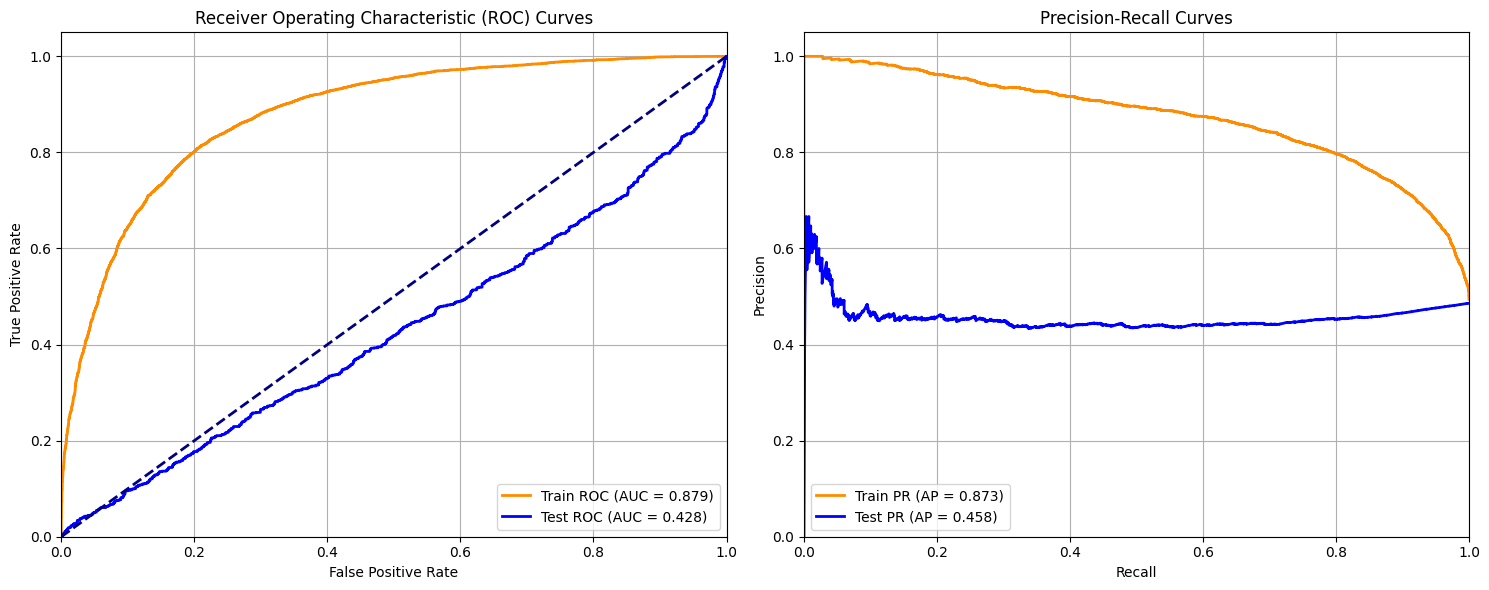

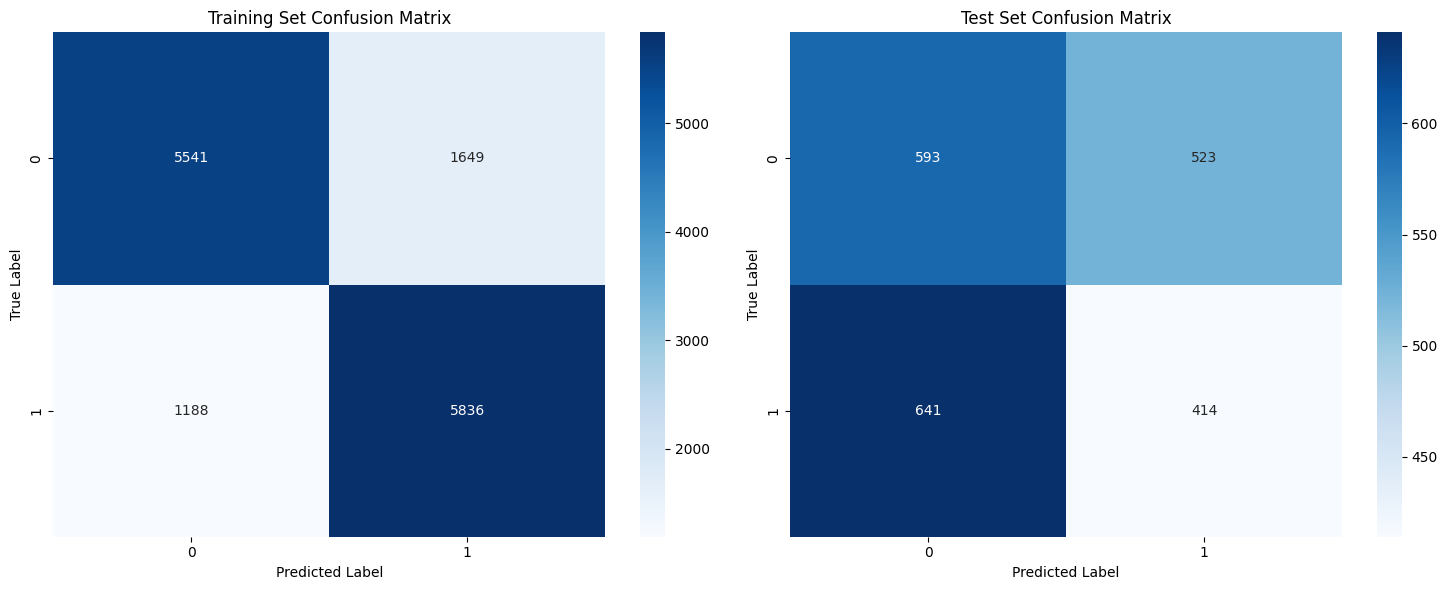

2012-06-30T00:00:00.000000000

train_size: 54585, test_size: 2446
Nº quarters train: 25, Nº quarters test: 1

Training Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.63      0.65     26676
         1.0       0.67      0.71      0.69     27909

    accuracy                           0.67     54585
   macro avg       0.67      0.67      0.67     54585
weighted avg       0.67      0.67      0.67     54585


Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.45      0.44      1047
         1.0       0.57      0.56      0.57      1399

    accuracy                           0.51      2446
   macro avg       0.50      0.50      0.50      2446
weighted avg       0.51      0.51      0.51      2446



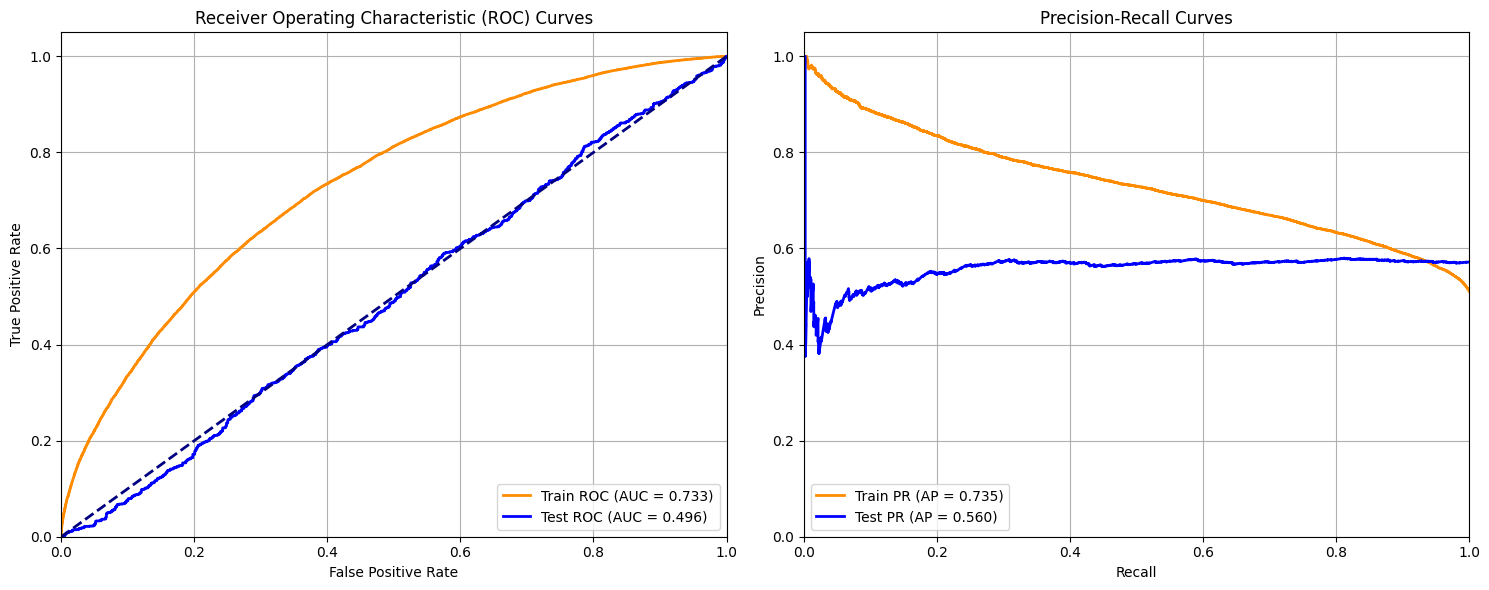

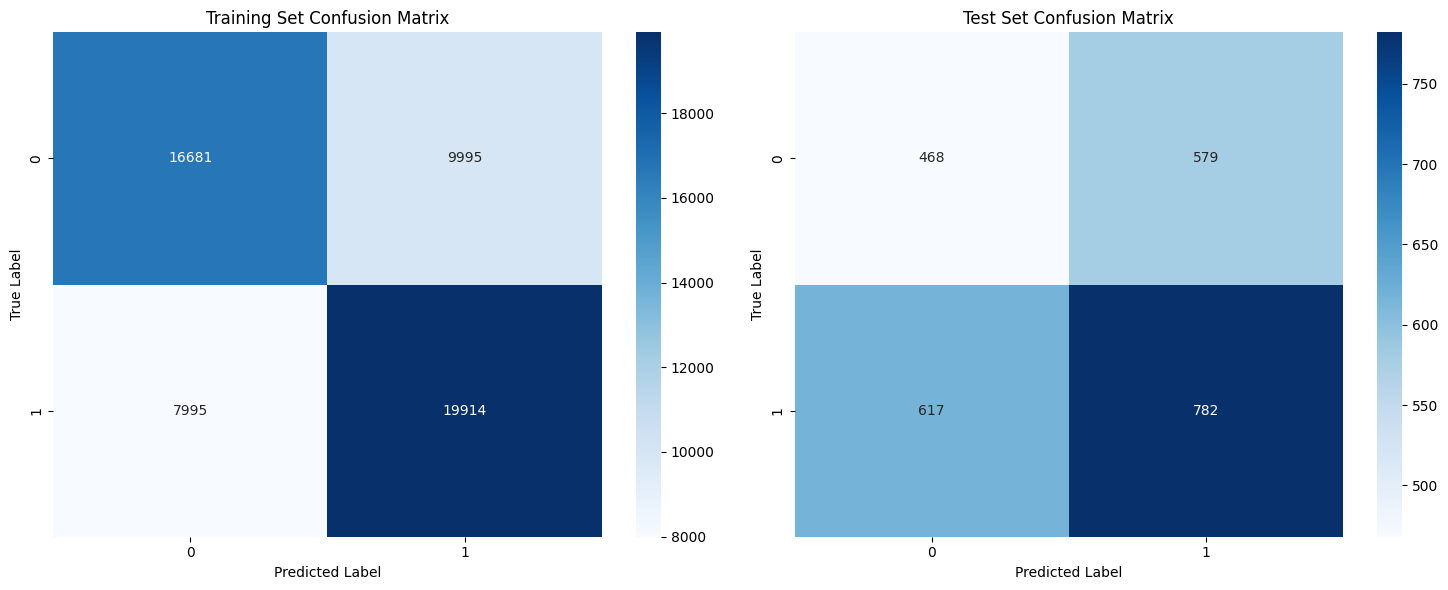

2019-12-30T00:00:00.000000000

train_size: 98353, test_size: 3472
Nº quarters train: 36, Nº quarters test: 1

Training Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.78      0.69     52273
         1.0       0.65      0.46      0.54     46080

    accuracy                           0.63     98353
   macro avg       0.63      0.62      0.61     98353
weighted avg       0.63      0.63      0.62     98353


Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.68      0.67      2236
         1.0       0.38      0.35      0.36      1236

    accuracy                           0.56      3472
   macro avg       0.52      0.52      0.52      3472
weighted avg       0.56      0.56      0.56      3472



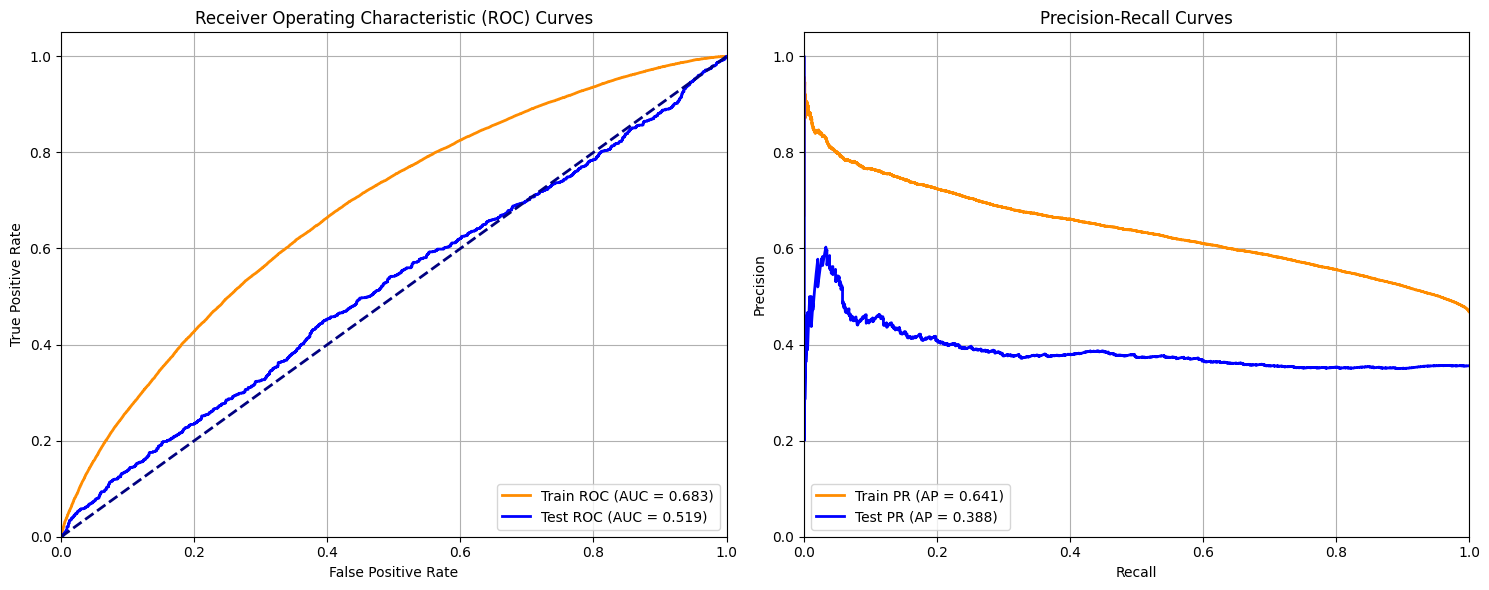

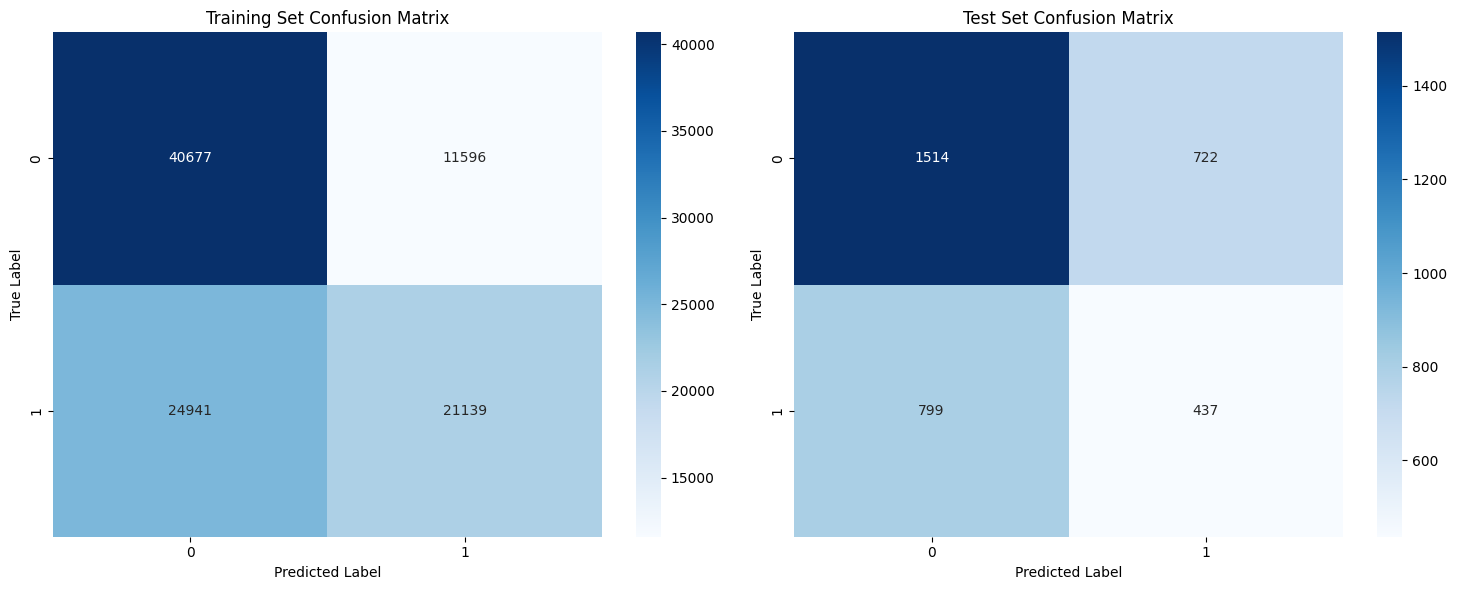

In [95]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
all_probs = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test, y_train, y_test, all_probs = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,all_probs,n_trees,False)
    fig, (ax1, ax2) = evaluate_model_performance(y_train, all_probs[execution_date.astype(str)][0], y_test, all_probs[execution_date.astype(str)][1])
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [96]:
print(all_results)

{numpy.datetime64('2007-12-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss', [0.6819827199754311, 0.6730960321143985, 0.6641741480158103, 0.6566424428338097, 0.6495223032207104, 0.6434783949301303, 0.6376677258823895, 0.6322862390554295, 0.626647660813731, 0.6221982354589984, 0.6178961399292654, 0.6136345059849695, 0.6101539485331807, 0.6060369752320014, 0.6022022075983251, 0.59884305869011, 0.595076216539263, 0.5919597625457921, 0.5886622241514067, 0.5855217422484665, 0.5820427089478879, 0.5786658750460775, 0.576244725411202, 0.5733656800997169, 0.5701951658764794, 0.5674611231351446, 0.5649237630683984, 0.5621596300127283, 0.5593036799661729, 0.5571882239127542, 0.5550568925901359, 0.5528052734334533, 0.5502825239250443, 0.5477151586036473, 0.5457326444265335, 0.5435317883286493, 0.5413472090905237, 0.5391059076739185, 0.5366167454261774, 0.5342797372060165]), ('weighted-return', [0.19885721957494934, 0.19166026170421865, 0.16750897134080484, 0.19078199548648872, 

In [97]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [98]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

print(test_results)

    binary_logloss  weighted-return  n_trees execution_date
0         0.698371         0.070648        0     2007-12-30
1         0.703729         0.014577        1     2007-12-30
2         0.709935         0.021468        2     2007-12-30
3         0.715846         0.011944        3     2007-12-30
4         0.722787         0.002005        4     2007-12-30
..             ...              ...      ...            ...
35        0.683110         0.016783       35     2019-12-30
36        0.683167         0.016783       36     2019-12-30
37        0.683366         0.016783       37     2019-12-30
38        0.683610         0.068219       38     2019-12-30
39        0.683777         0.068219       39     2019-12-30

[120 rows x 4 columns]


In [99]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

print(test_results_final_tree)

    binary_logloss  weighted-return  n_trees execution_date
39        0.861430        -0.034588       39     2007-12-30
39        0.710077         0.175964       39     2012-06-30
39        0.683777         0.068219       39     2019-12-30


And this are the results:

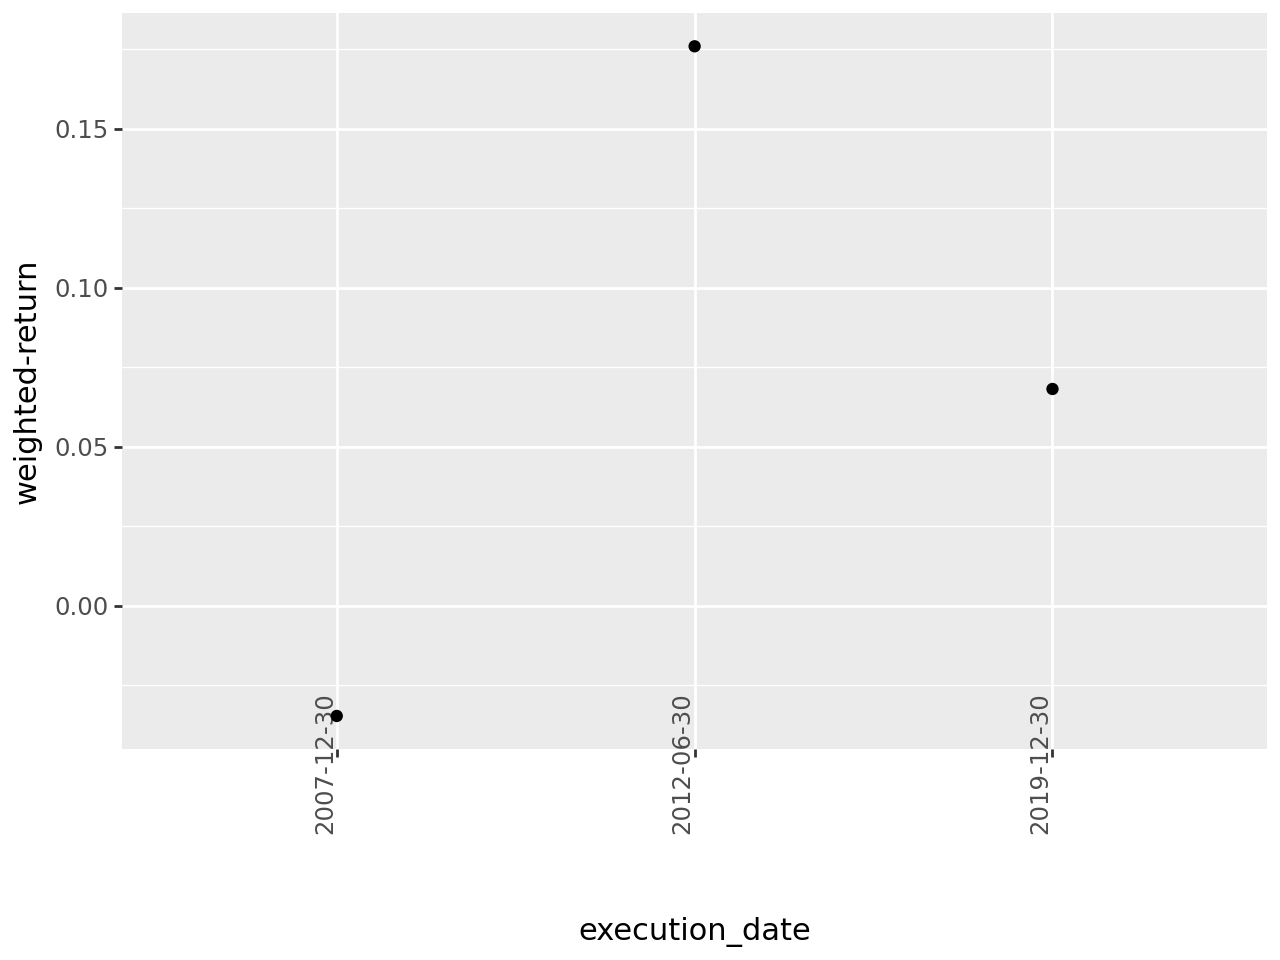

In [100]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



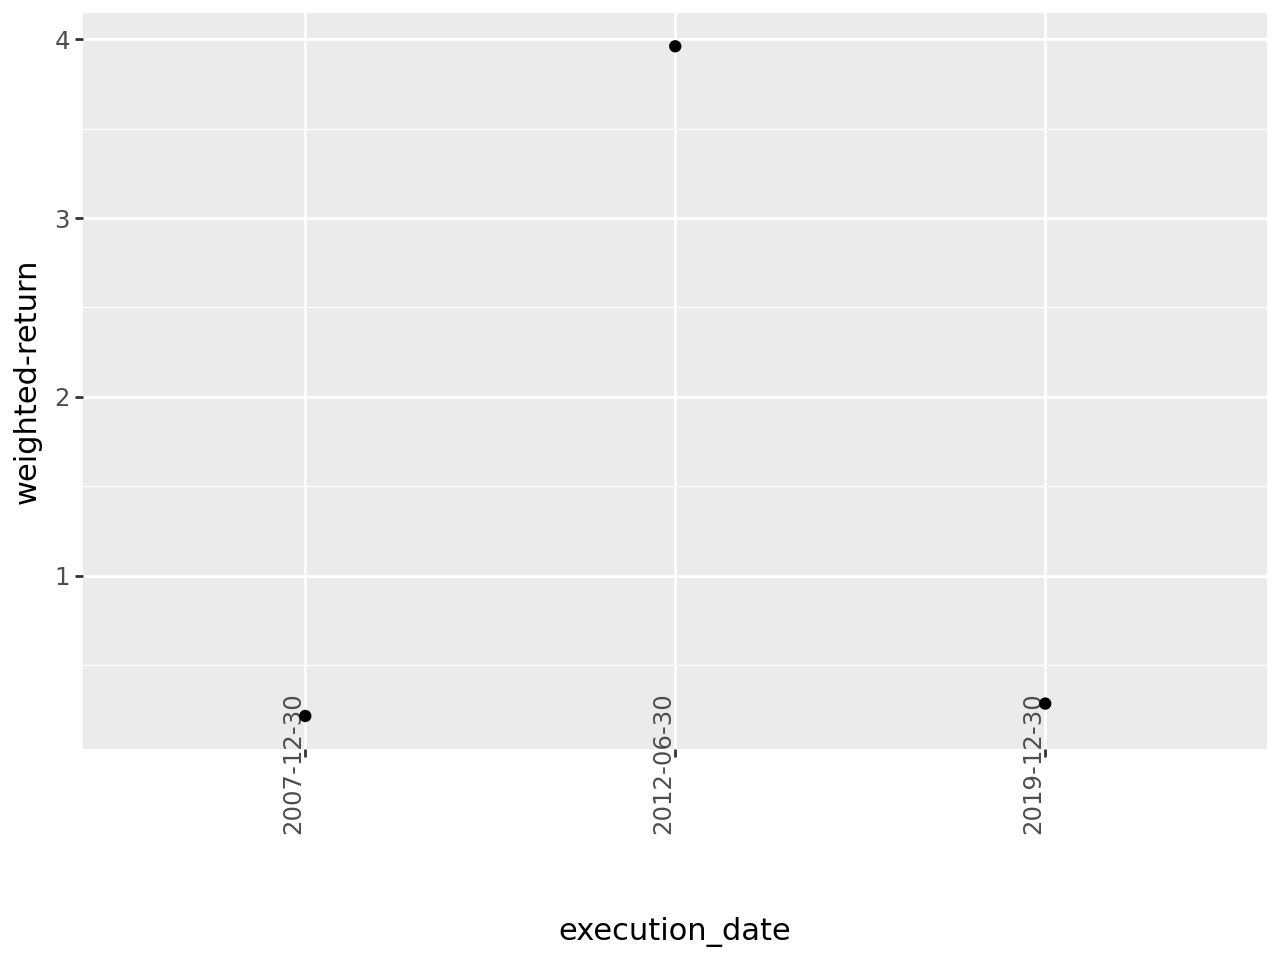

In [101]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* [ ] Try to see if there is any kind of data leakage or suspicious features

* ✅ If the training part is very slow, try to see how you can modify it to execute faster tests

* [ ] Try to understand if the algorithm is learning correctly

* ✅ We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones

* ✅ Try to see if there is overfitting

* [ ] Try to see if there is a lot of noise between different trainings

* [ ] To simplify, why if you only keep the first tickers in terms of Market Cap?
* [ ] Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [102]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [103]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

In [104]:
print(all_models.values())

dict_values([<lightgbm.basic.Booster object at 0x7d20b462b750>, <lightgbm.basic.Booster object at 0x7d20b45f6f10>, <lightgbm.basic.Booster object at 0x7d20b45c3750>])


2007-12-30T00:00:00.000000000


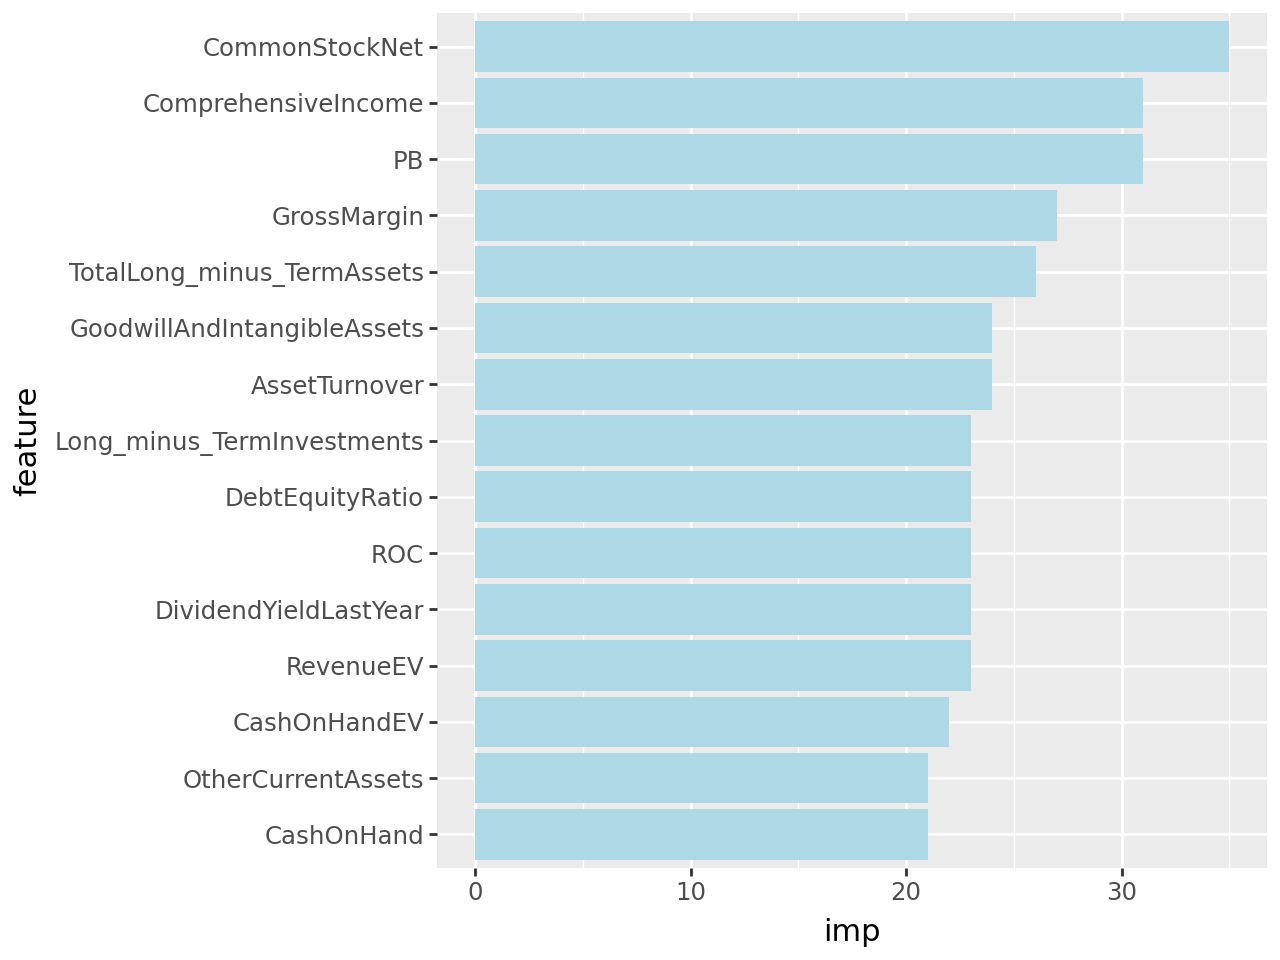

2012-06-30T00:00:00.000000000


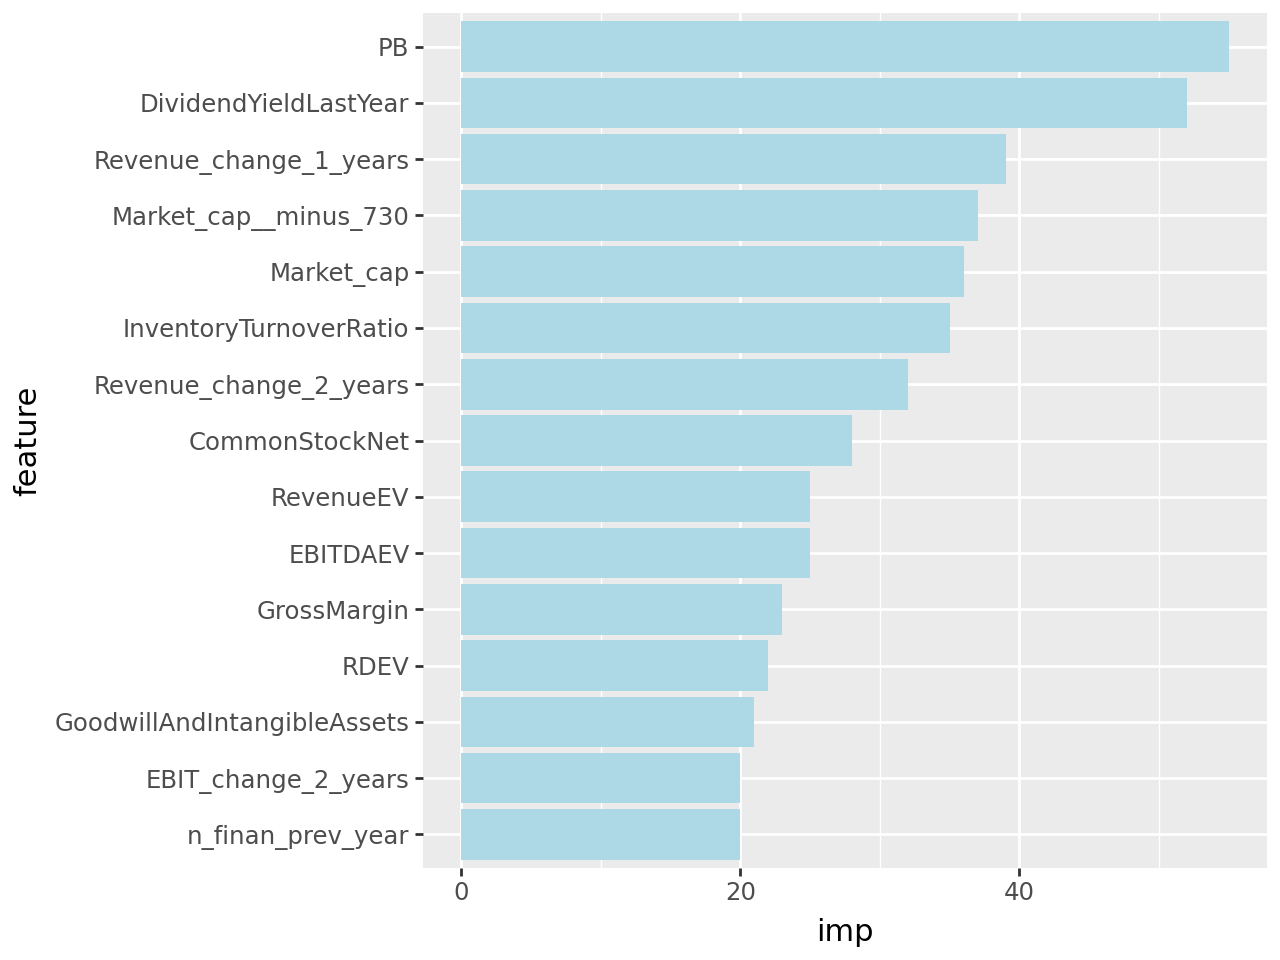

2019-12-30T00:00:00.000000000


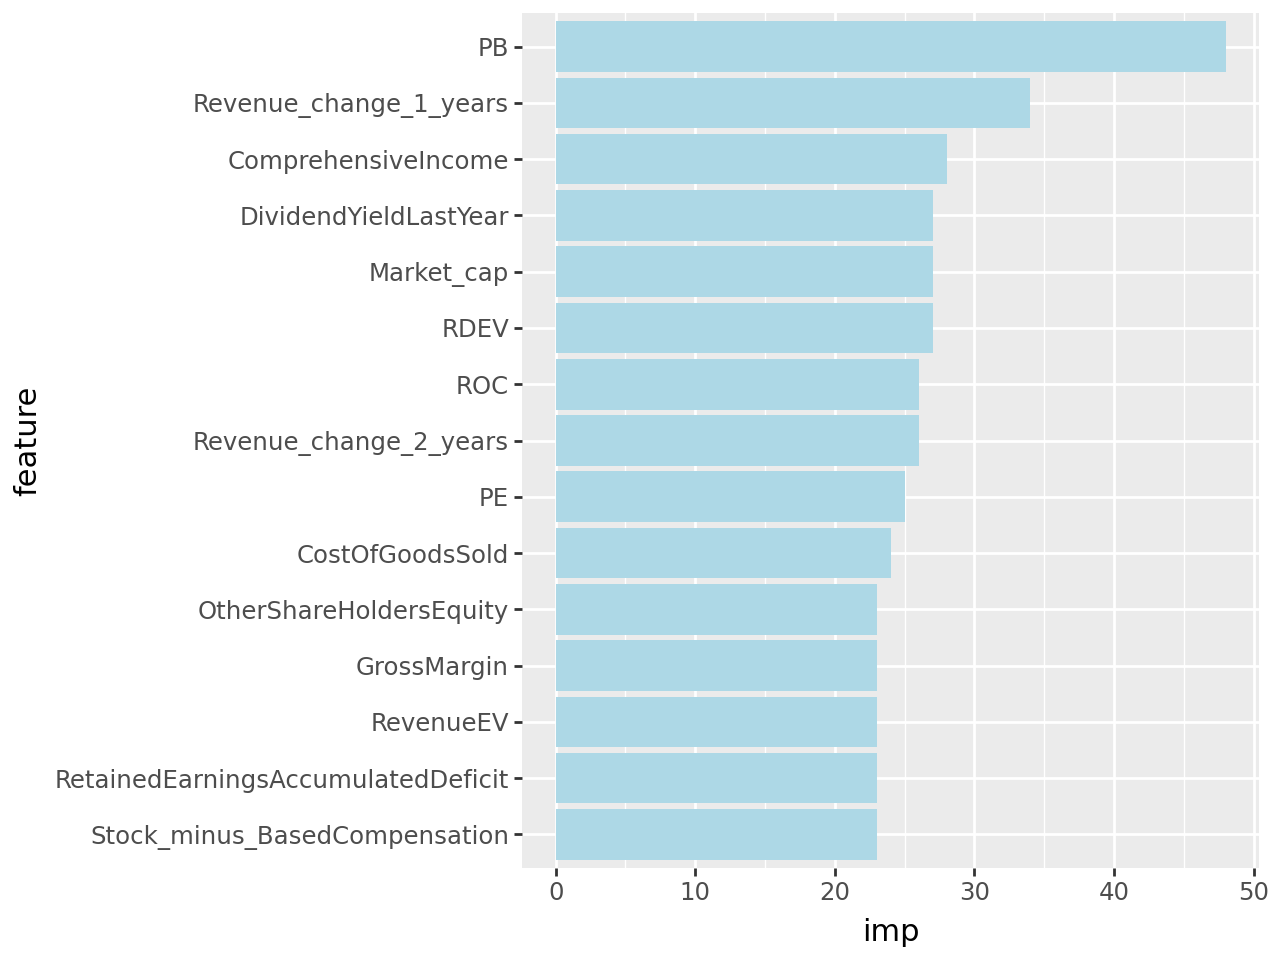

In [105]:
for key, value in all_models.items():
    print(key)
    print(value)
    plot = draw_feature_importance(all_models[key])
    plot.show()
